# 辨识手写英文字母数字模型训练

## 步骤1：导入依赖

In [14]:
# 可视化依赖
from IPython.display import Image, SVG
import seaborn as sns

# 文件路径、Numpy、Tensorflow
import os
import gzip
import numpy as np
import tensorflow as tf
from scipy.io import loadmat

# Keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# 设置中文字体为 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

# 忽略警告消息
import warnings
warnings.filterwarnings('ignore')

sns.set_theme()

## 步骤2：安装 EMNIST 并加载数据

In [15]:
%pip install --no-cache-dir emnist

# 参考文档
# [EMNIST 说明](https://pypi.org/project/emnist/)
# [数据集 说明](https://www.nist.gov/itl/products-and-services/emnist-dataset)

def load_mnist(path, kind='train'):
    """加载 MNIST 数据"""
    labels_path = os.path.join(path, f'emnist-letters-{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'emnist-letters-{kind}-images-idx3-ubyte.gz')
    
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
    
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)
    
    return images, labels

# 设置数据集路径
data_path = r"./data/emnist_data"  # 请根据实际位置修改此路径

# 加载训练和测试数据
x_train, y_train = load_mnist(data_path, kind='train')
x_test, y_test = load_mnist(data_path, kind='test')

# 重塑图像为28x28
x_train = x_train.reshape(-1, 28, 28).astype(np.float32)
x_test = x_test.reshape(-1, 28, 28).astype(np.float32)

# 打印数据集形状
print("训练集形状:", x_train.shape, y_train.shape)
print("测试集形状:", x_test.shape, y_test.shape)

# 显示可用的类别
unique_classes = np.unique(y_train)
print("可用的类别:", unique_classes)
print("类别数量:", len(unique_classes))

# 将标签映射到A-Z（EMNIST字母数据集中，1-26对应A-Z）
class_names = [chr(i + 64) for i in range(1, 27)]
print("类别名称:", class_names)


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



训练集形状: (124800, 28, 28) (124800,)
测试集形状: (20800, 28, 28) (20800,)
可用的类别: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
类别数量: 26
类别名称: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## 步骤3：数据可视化

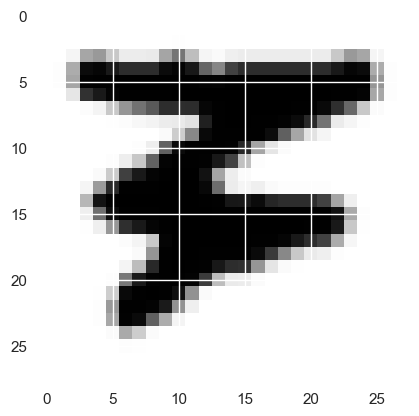

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
[22  6 15 14 22 16 12 10 21 23]


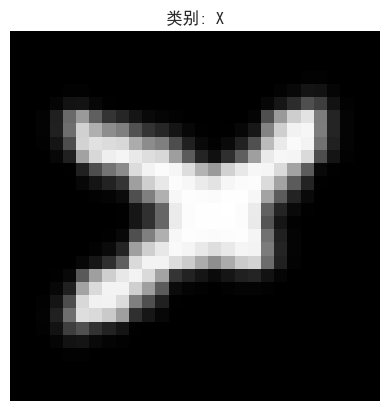

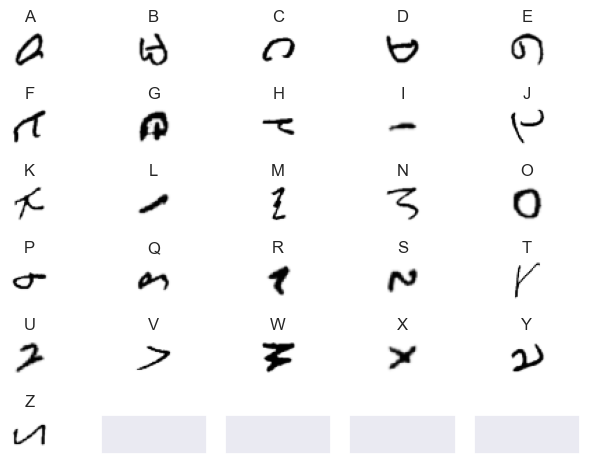

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

# 显示第1张图片
plt.imshow(x_train[0,:,:], cmap=plt.cm.Greys)
plt.show()

# 调整标签值（从0开始）
y_train = y_train - 1
y_test = y_test - 1
print(np.unique(y_train))

# 显示前10个标签
print(y_train[:10])

# 显示第9张图片及其类别
no = 9
plt.imshow(x_train[no,:,:], cmap='gray')
plt.title(f"类别: {class_names[y_train[no]]}",fontproperties='SimHei')
plt.axis('off')
plt.show()

# 显示每个类别的第一张图片
fig, ax = plt.subplots(nrows=6, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(26):
    img = x_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    ax[i].set_title(class_names[i])
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 步骤4：数据预处理

In [17]:
# 特征缩放，使用归一化 (Normalization)，范围缩放至 (0, 1)
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0

# 显示第1张归一化后的图片数据
print(x_train_norm[0])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.00392157 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.07843138 0.44705883 0.49019608 0.32156864
  0.14509805 0.14509805 0.15294118 0.4509804  0.6156863  0.36862746
  0

## 步骤5：构建模型

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 构建模型
model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=26, activation='softmax')
])

# 设置优化器(optimizer)、损失函数(loss)、性能衡量指标(metrics)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,970 (480.35 KB)

 Trainable params: 122,970 (480.35 KB)

 Non-trainable params: 0 (0.00 B)

## 步骤6：训练模型

In [19]:
# 训练模型
history = model.fit(x_train_norm, y_train, epochs=100, batch_size=1000, validation_split=0.2)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.2873 - loss: 2.4621 - val_accuracy: 0.7779 - val_loss: 0.7740
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.6658 - loss: 1.0808 - val_accuracy: 0.8502 - val_loss: 0.5052
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7428 - loss: 0.8267 - val_accuracy: 0.8697 - val_loss: 0.4128
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7787 - loss: 0.7067 - val_accuracy: 0.8824 - val_loss: 0.3708
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7935 - loss: 0.6567 - val_accuracy: 0.8902 - val_loss: 0.3457
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8106 - loss: 0.5979 - val_accuracy: 0.8988 - val_loss: 0.3218
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8204 - loss: 0.5679 - val_accuracy: 0.9016 - val_loss: 0.3102
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8291 - loss: 0.5423 - 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


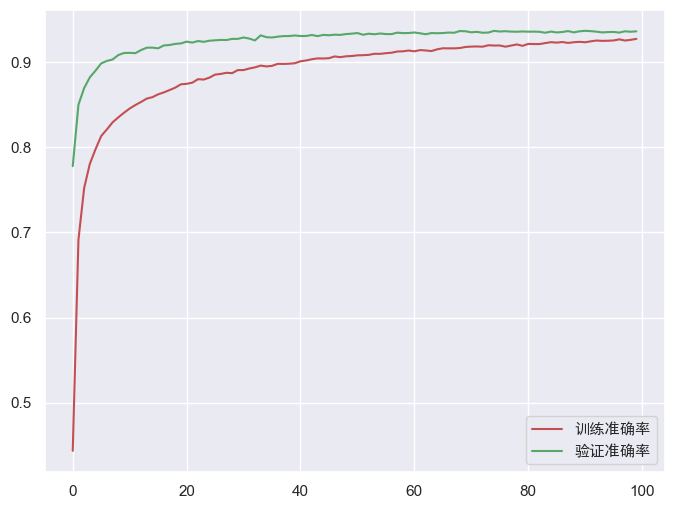

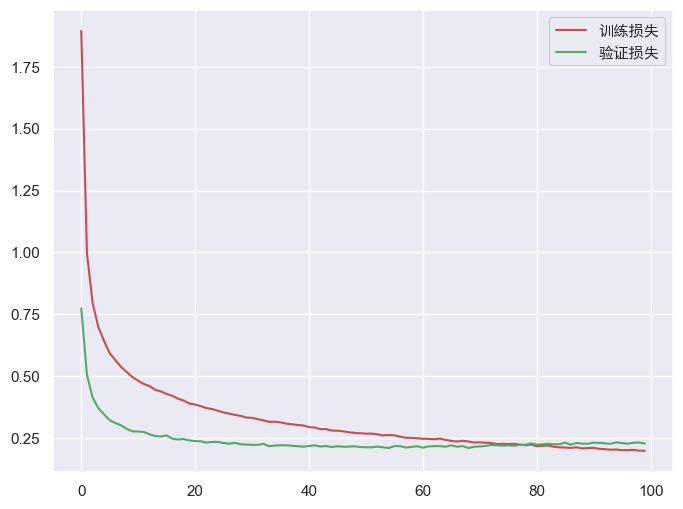

In [20]:
# 检查训练过程
print(history.history.keys())

# 对训练过程的准确率绘图
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'r', label='训练准确率')
plt.plot(history.history['val_accuracy'], 'g', label='验证准确率')
plt.legend(prop={'family': 'SimHei'})
plt.show()

# 对训练过程的损失绘图
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], 'r', label='训练损失')
plt.plot(history.history['val_loss'], 'g', label='验证损失')
plt.legend(prop={'family': 'SimHei'})
plt.show()

## 步骤7：评估模型

In [21]:
# 评估模型
score = model.evaluate(x_test_norm, y_test, verbose=0)
for i, metric in enumerate(model.metrics_names):
    print(f'{metric}: {score[i]:.4f}')

loss: 0.2372
compile_metrics: 0.9345


## 步骤8：预测并可视化结果

650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
真实标签: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
预测标签: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
预测概率: [[0.97 0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


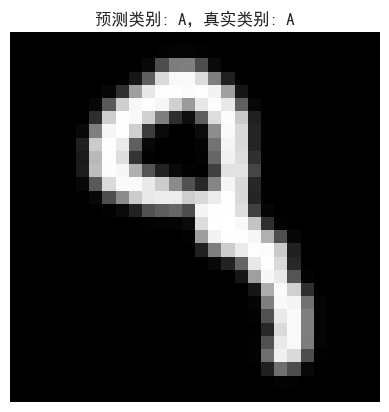

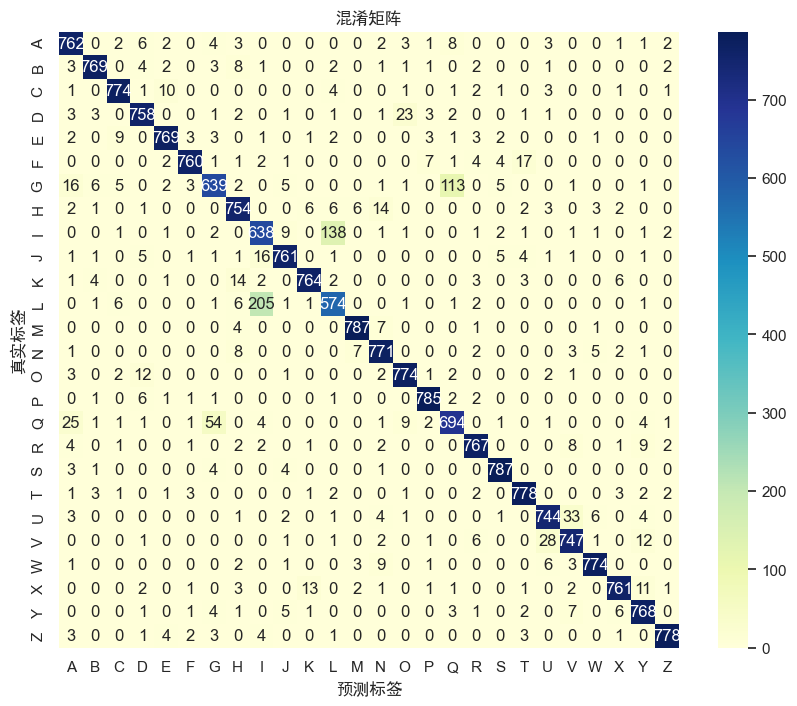

类别 A 的准确率: 0.95
类别 B 的准确率: 0.96
类别 C 的准确率: 0.97
类别 D 的准确率: 0.95
类别 E 的准确率: 0.96
类别 F 的准确率: 0.95
类别 G 的准确率: 0.80
类别 H 的准确率: 0.94
类别 I 的准确率: 0.80
类别 J 的准确率: 0.95
类别 K 的准确率: 0.95
类别 L 的准确率: 0.72
类别 M 的准确率: 0.98
类别 N 的准确率: 0.96
类别 O 的准确率: 0.97
类别 P 的准确率: 0.98
类别 Q 的准确率: 0.87
类别 R 的准确率: 0.96
类别 S 的准确率: 0.98
类别 T 的准确率: 0.97
类别 U 的准确率: 0.93
类别 V 的准确率: 0.93
类别 W 的准确率: 0.97
类别 X 的准确率: 0.95
类别 Y 的准确率: 0.96
类别 Z 的准确率: 0.97


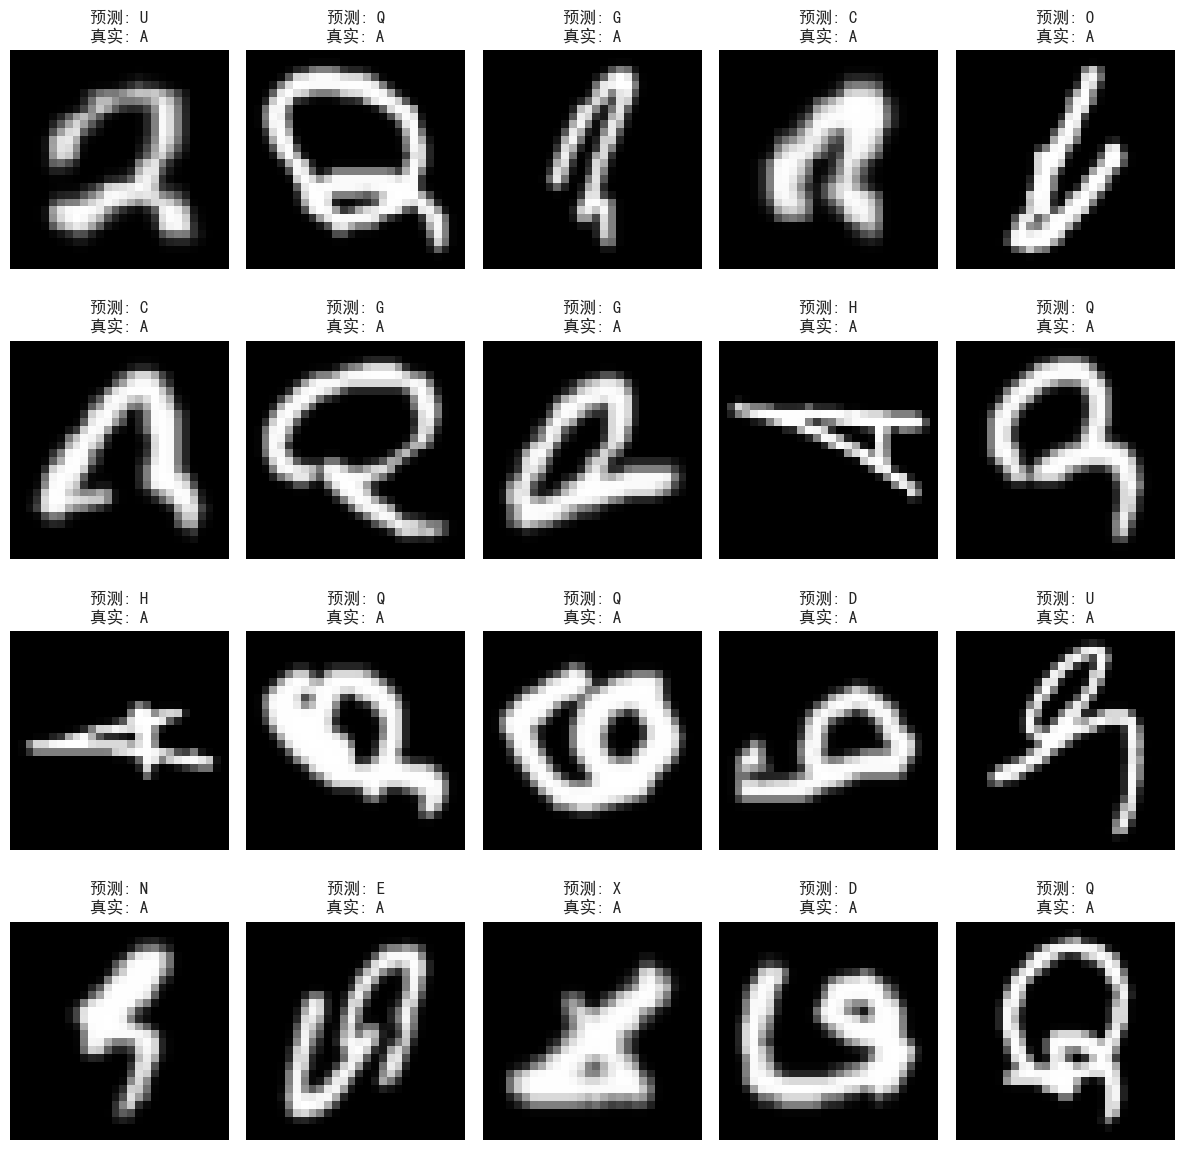

In [24]:
import numpy as np

# 进行预测
predictions = np.argmax(model.predict(x_test_norm), axis=-1)

# 显示前20个真实标签和预测标签
print('真实标签:', y_test[:20])
print('预测标签:', predictions[:20])

# 显示第9张图片的预测概率
prediction = model.predict(x_test_norm[8:9])
print(f'预测概率: {np.around(prediction, 2)}')

# 显示第9张图片及其预测结果
plt.imshow(x_test[8, :, :], cmap='gray')
plt.title(f"预测类别: {class_names[predictions[8]]}，真实类别: {class_names[y_test[8]]}", fontproperties='SimHei')
plt.axis('off')
plt.show()

# 可视化混淆矩阵
conf_mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
plt.title('混淆矩阵', fontproperties='SimHei')
plt.xlabel('预测标签', fontproperties='SimHei')
plt.ylabel('真实标签', fontproperties='SimHei')
plt.show()

# 打印每个类别的预测准确率
for i, class_name in enumerate(class_names):
    correct_preds = np.sum((y_test == i) & (predictions == i))
    total_preds = np.sum(y_test == i)
    accuracy = correct_preds / total_preds if total_preds > 0 else 0
    print(f"类别 {class_name} 的准确率: {accuracy:.2f}")

# 显示前20个预测错误的图片及其预测结果
incorrect_indices = np.where(predictions != y_test)[0]
plt.figure(figsize=(12, 12))
for i, idx in enumerate(incorrect_indices[:20]):
    plt.subplot(4, 5, i+1)
    plt.imshow(x_test[idx, :, :], cmap='gray')
    plt.title(f"预测: {class_names[predictions[idx]]}\n真实: {class_names[y_test[idx]]}", fontproperties='SimHei')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 步骤9：保存和加载模型

In [25]:
from datetime import datetime

# 定义模型名称、数据集名称和重要参数
model_name = 'CNN'
dataset_name = 'MNIST'
epochs = 50
batch_size = 32

# 获取当前日期
current_date = datetime.now().strftime("%Y%m%d")

# 生成模型文件名
model_filename = f"{model_name}_{dataset_name}_{current_date}_epochs_{epochs}_batch_size_{batch_size}.h5"

# 定义保存目录
save_dir = 'models'

# 生成完整的文件路径
model_filepath = os.path.join(save_dir, model_filename)

# 保存模型
model.save(model_filepath)

print(f"模型已保存为 {model_filename}")

# 加载模型
# model = tf.keras.models.load_model(model_filename)